# HSCT survival: classification

## Notebook set-up

In [1]:
import pickle
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)
gpu=0
notebook_num='02.4'

# Input files
datasets_definitions_file=f'{config.DATA_PATH}/processed/02.1-dataset_definitions.pkl'
coxph_survival_file=f'{config.PROCESSED_DATA}/02.1-coxPH_survival.pkl'
weibullaft_survival_file=f'{config.PROCESSED_DATA}/02.2-weibullAFT_survival.pkl'
kld_features_file=f'{config.PROCESSED_DATA}/02.3-kld_survival.pkl'

# Output files

# EFS+/- split regression results
efs_split_regression_results_file=f'{config.RESULTS}/{notebook_num}-efs_split_regression_results.pkl'

# Testing of different encoding strategies datasets for clustering
datasets_clustering_results_file=f'{config.RESULTS}/{notebook_num}-datasets_clustering_results.pkl'

# Testing regression on predicted EFS clusters
clustered_regression_results_file=f'{config.RESULTS}/{notebook_num}-clustered_regression_results.pkl'

# Run parameters
randomsearch_depth=100

test_split_regression=True
test_data_tree_clustering=True
clustered_regression_test=True
train_nn=True

## 1. Data loading

### 1.1. Base data

In [2]:
# Load dataset definitions
with open(datasets_definitions_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print('Datasets:\n')
for description, filepath in datasets.items():
    print(f' {description}')

# Load one of the datasets
with open(datasets['Nominal one-hot/ordinal encoded, NANs imputed'], 'rb') as input_file:
    data_dict=pickle.load(input_file)

Datasets:

 Nominal one-hot/ordinal encoded, NANs encoded
 Nominal one-hot/ordinal encoded, NANs imputed
 All ordinal encoded, NAN encoded
 All ordinal encoded, NAN imputed
 Binary target encoded
 Continuous target encoded


### 1.2. Engineered survival features

In [3]:
# Load Cox Proportional Hazard model features
with open(coxph_survival_file, 'rb') as input_file:
    coxph_features=pickle.load(input_file)

print('\nCox PH features:\n')
for key, value in coxph_features.items():
    print(f' {key}: {value[:3]}...')

# Load Weibull Accelerated Failure Time model features
with open(weibullaft_survival_file, 'rb') as input_file:
    weibullaft_features=pickle.load(input_file)

print('\nWeibull AFT features:\n')
for key, value in weibullaft_features.items():
    print(f' {key}: {value[:3]}...')

training_features_df=data_dict['Training features']
training_features_df['CoxPH survival']=coxph_features['Training survival']
training_features_df['CoxPH partial hazard']=coxph_features['Training partial hazard']
training_features_df['WeibullAFT survival']=weibullaft_features['Training survival']
training_features_df['WeibullAFT expectation']=weibullaft_features['Training expectation']

testing_features_df=data_dict['Testing features']
testing_features_df['CoxPH survival']=coxph_features['Testing survival']
testing_features_df['CoxPH partial hazard']=coxph_features['Testing partial hazard']
testing_features_df['WeibullAFT survival']=weibullaft_features['Testing survival']
testing_features_df['WeibullAFT expectation']=weibullaft_features['Testing expectation']


Cox PH features:

 Training survival: [0.24363680461980738, 0.3637444006253749, 0.5168019777019127]...
 Training partial hazard: [1.8803475495482613, 1.3466710176620955, 0.8789954421143673]...
 Testing survival: [0.6370020963218854, 0.5546538101662734, 0.2863375999586331]...
 Testing partial hazard: [0.6005364601191192, 0.7848708147963167, 1.6653005697334142]...

Weibull AFT features:

 Training survival: [0.0638806843197926, 0.09949424178131851, 0.26804119781379776]...
 Training expectation: [46.46475765157041, 59.920348644701036, 135.04197583316332]...
 Testing survival: [0.253938984076257, 0.1987854679458247, 0.014252024249743594]...
 Testing expectation: [0.253938984076257, 0.1987854679458247, 0.014252024249743594]...


### 1.3. Kullback-Leibler divergence

In [4]:
# Load KLD features
with open(kld_features_file, 'rb') as input_file:
    kld_features=pickle.load(input_file)

print('\nKLD features:\n')
for key, value in kld_features.items():
    print(f' {key}: {value[:3]}...')

training_features_df['CoxPH survival KLD']=kld_features['Training CoxPH survival KLD']
training_features_df['CoxPH partial hazard KLD']=kld_features['Training CoxPH partial hazard KLD']
training_features_df['WeibullAFT survival KLD']=kld_features['Training WeibullAFT survival KLD']
training_features_df['WeibullAFT expectation KLD']=kld_features['Training WeibullAFT expectation KLD']
testing_features_df['CoxPH survival KLD']=kld_features['Testing CoxPH survival KLD']
testing_features_df['CoxPH partial hazard KLD']=kld_features['Testing CoxPH partial hazard KLD']
testing_features_df['WeibullAFT survival KLD']=kld_features['Testing WeibullAFT survival KLD']
testing_features_df['WeibullAFT expectation KLD']=kld_features['Testing WeibullAFT expectation KLD']


KLD features:

 Training CoxPH survival KLD: [0.01352103 0.01688722 0.1891981 ]...
 Training CoxPH partial hazard KLD: [0.0117275  0.02008992 0.15559196]...
 Training WeibullAFT survival KLD: [0.12233805 0.16759362 0.20228648]...
 Training WeibullAFT expectation KLD: [0.03011926 0.08412324 0.18947346]...
 Testing CoxPH survival KLD: [0.24151578 0.22347724 0.00244256]...
 Testing CoxPH partial hazard KLD: [0.18236062 0.17837742 0.00326816]...
 Testing WeibullAFT survival KLD: [0.20244026 0.19388513 0.03401398]...
 Testing WeibullAFT expectation KLD: [2.59040224e-056 3.88805702e-070 4.58090256e-318]...


### 1.4. Labels

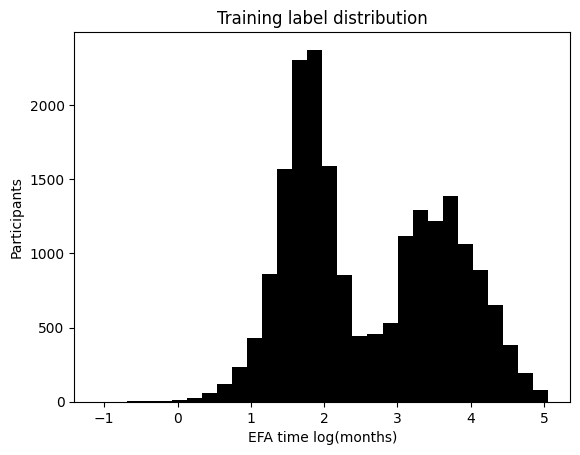

In [5]:
training_labels_df=data_dict['Training labels']
training_labels_df['efs_time']=np.log(training_labels_df['efs_time'])

testing_labels_df=data_dict['Testing labels']
testing_labels_df['efs_time']=np.log(testing_labels_df['efs_time'])

plt.title('Training label distribution')
plt.hist(training_labels_df['efs_time'], color='black', bins=30)
plt.xlabel('EFA time log(months)')
plt.ylabel('Participants')
plt.show()

### 1.5. Race group & ID

In [6]:
training_race_groups=data_dict['Training race group']
training_ids=data_dict['Training IDs']

testing_race_groups=data_dict['Testing race group']
testing_ids=data_dict['Testing IDs']

## 2. Does knowing the EFS label give better regression results?

### 2.1. Dataset preparation

In [7]:
if test_split_regression == True:

    # Combine and split the data by EFS label
    training_features_df['efs']=training_labels_df['efs']
    training_features_df['race_group']=training_race_groups
    training_features_df['ID']=training_ids

    training_efs_zero_features_df=training_features_df[training_features_df['efs'] == 0].copy()
    training_efs_zero_race_groups=training_efs_zero_features_df['race_group']
    training_efs_zero_ids=training_efs_zero_features_df['ID']

    training_efs_one_features_df=training_features_df[training_features_df['efs'] == 1].copy()
    training_efs_one_race_groups=training_efs_one_features_df['race_group']
    training_efs_one_ids=training_efs_one_features_df['ID']

    training_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)
    training_efs_zero_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)
    training_efs_one_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)

    training_efs_zero_labels_df=training_labels_df[training_labels_df['efs'] == 0].copy()
    training_efs_one_labels_df=training_labels_df[training_labels_df['efs'] == 1].copy()

    testing_features_df['efs']=testing_labels_df['efs']
    testing_features_df['race_group']=testing_race_groups
    testing_features_df['ID']=testing_ids

    testing_efs_zero_features_df=testing_features_df[testing_features_df['efs'] == 0].copy()
    testing_efs_zero_race_groups=testing_efs_zero_features_df['race_group']
    testing_efs_zero_ids=testing_efs_zero_features_df['ID']

    testing_efs_one_features_df=testing_features_df[testing_features_df['efs'] == 1].copy()
    testing_efs_one_race_groups=testing_efs_one_features_df['race_group']
    testing_efs_one_ids=testing_efs_one_features_df['ID']

    testing_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)
    testing_efs_zero_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)
    testing_efs_one_features_df.drop(['efs','race_group','ID'], inplace=True, axis=1)

    testing_efs_zero_labels_df=testing_labels_df[testing_labels_df['efs'] == 0].copy()
    testing_efs_one_labels_df=testing_labels_df[testing_labels_df['efs'] == 1].copy()

    split_datasets={
        'Combined':{
            'Training features': training_features_df,
            'Training labels': training_labels_df,
            'Training race groups': training_race_groups,
            'Training IDs': training_ids,
            'Testing features': testing_features_df,
            'Testing labels': testing_labels_df,
            'Testing race groups': testing_race_groups,
            'Testing IDs': testing_ids
        },
        'EFS 0': {
            'Training features': training_efs_zero_features_df,
            'Training labels': training_efs_zero_labels_df,
            'Training race groups': training_efs_zero_race_groups,
            'Training IDs': training_efs_zero_ids,
            'Testing features': testing_efs_zero_features_df,
            'Testing labels': testing_efs_zero_labels_df,
            'Testing race groups': testing_efs_zero_race_groups,
            'Testing IDs': testing_efs_zero_ids
        },
        'EFS 1': {
            'Training features': training_efs_one_features_df,
            'Training labels': training_efs_one_labels_df,
            'Training race groups': training_efs_one_race_groups,
            'Training IDs': training_efs_one_ids,
            'Testing features': testing_efs_one_features_df,
            'Testing labels': testing_efs_one_labels_df,
            'Testing race groups': testing_efs_one_race_groups,
            'Testing IDs': testing_efs_one_ids
        }
    }

### 2.2. XGBoost regression

In [8]:
if test_split_regression == True:

    hyperparameters={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 315,
        'learning_rate': 0.01,
        'max_depth': 6,
        'gamma': 0.01,
        'subsample': 0.5
    }

    if gpu != None:
        hyperparameters['gpu_id']=gpu
        hyperparameters['tree_method']='gpu_hist'

    regression_predictions={
        'Training':{},
        'Testing': {}
    }

    training_scoring_results={
        'Model': [],
        'RMSE': [],
        'C-index': [],
        'Stratified C-index': []
    }

    testing_scoring_results={
        'Model': [],
        'RMSE': [],
        'C-index': [],
        'Stratified C-index': []
    }

    # Loop on the datasets
    for dataset, datasets in split_datasets.items():

        print(dataset)

        dtraining=xgb.DMatrix(
            datasets['Training features'],
            label=datasets['Training labels']['efs_time']
        )
        dtesting=xgb.DMatrix(
            datasets['Testing features'],
            label=datasets['Testing labels']['efs_time']
        )

        tree_model=xgb.train(
            hyperparameters,
            dtraining,
            num_boost_round=1000,
            evals=[(dtesting, 'testing')],
            early_stopping_rounds=100,
            verbose_eval=0
        )

        # Make training predictions
        predictions=tree_model.predict(dtraining)
        regression_predictions['Training'][dataset]=predictions

        # Make testing predictions
        predictions=tree_model.predict(dtesting)
        regression_predictions['Testing'][dataset]=predictions

Combined
EFS 0
EFS 1


### 2.4. Results


      Model      RMSE   C-index  Stratified C-index
0  Combined  0.954537  0.652674            0.641485
1     Split  0.303351  0.899126            0.887608


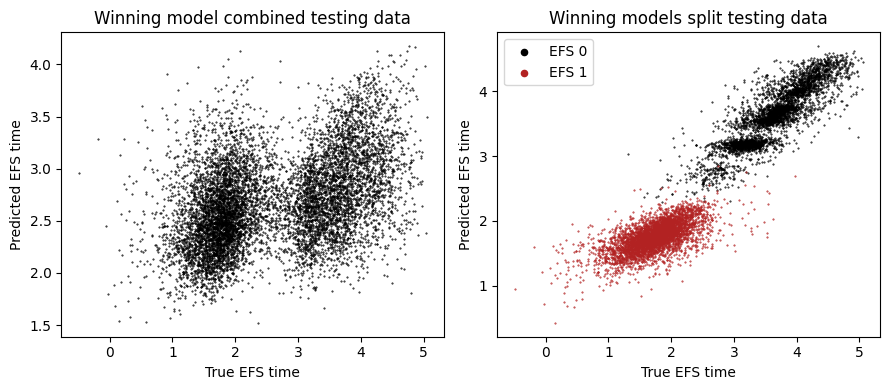

In [9]:
split_predictions=list(regression_predictions['Testing']['EFS 0']) + list(regression_predictions['Testing']['EFS 1']),
split_labels=list(split_datasets['EFS 0']['Testing labels']['efs_time']) + list(split_datasets['EFS 1']['Testing labels']['efs_time']),
split_efs=list(split_datasets['EFS 0']['Testing labels']['efs']) + list(split_datasets['EFS 1']['Testing labels']['efs']),
split_race_group=list(split_datasets['EFS 0']['Testing race groups']) + list(split_datasets['EFS 1']['Testing race groups']),
split_id=list(split_datasets['EFS 0']['Testing IDs']) + list(split_datasets['EFS 1']['Testing IDs'])

scoring_results=helper_funcs.score_predictions(
    'Combined',
    regression_predictions['Testing']['Combined'],
    split_datasets['Combined']['Testing labels']['efs_time'].values,
    split_datasets['Combined']['Testing labels']['efs'].values,
    split_datasets['Combined']['Testing race groups'],
    split_datasets['Combined']['Testing IDs']
)

scoring_results=helper_funcs.score_predictions(
    'Split',
    np.array(split_predictions).flatten(),
    np.array(split_labels).flatten(),
    np.array(split_efs).flatten(),
    np.array(split_race_group).flatten(),
    np.array(split_id).flatten(),
    results=scoring_results
)

scoring_results_df=pd.DataFrame(scoring_results)
print(f'\n{scoring_results_df.head()}')

fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

axs[0].set_title(f'Winning model combined testing data')
axs[0].scatter(
    split_datasets['Combined']['Testing labels']['efs_time'].values,
    regression_predictions['Testing']['Combined'], 
    color='black',
    s=0.2
)

axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title(f'Winning models split testing data')
axs[1].scatter(
    split_datasets['EFS 0']['Testing labels']['efs_time'],
    regression_predictions['Testing']['EFS 0'],
    s=0.2,
    color='black',
    label='EFS 0'
)
axs[1].scatter(
    split_datasets['EFS 1']['Testing labels']['efs_time'],
    regression_predictions['Testing']['EFS 1'],
    s=0.2,
    color='firebrick',
    label='EFS 1'
)
axs[1].set_xlabel('True EFS time')
axs[1].set_ylabel('Predicted EFS time')
axs[1].legend(loc='upper left',markerscale=10)

fig.tight_layout()
fig.show()

## 3. Classification

### 3.1. XGBoost model training

In [10]:
# Calculated class weighting
class_weight=(len(training_labels_df) - sum(training_labels_df['efs'])) / sum(training_labels_df['efs'])

hyperparameters={
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 315,
    'scale_pos_weight': class_weight,
    'learning_rate': 0.01,
    'max_depth': 6,
    'gamma': 0.01,
    'subsample': 0.5
}

if gpu != None:
    hyperparameters['gpu_id']=gpu
    hyperparameters['tree_method']='gpu_hist'

dtraining=xgb.DMatrix(
    training_features_df,
    label=training_labels_df['efs']
)
dtesting=xgb.DMatrix(
    testing_features_df,
    label=testing_labels_df['efs']
)

tree_model=xgb.train(
    hyperparameters,
    dtraining,
    num_boost_round=1000,
    evals=[(dtesting, 'testing')],
    early_stopping_rounds=100,
    verbose_eval=0
)

# Make training predictions
training_predictions=tree_model.predict(dtraining)

# Make testing predictions
testing_predictions=tree_model.predict(dtesting)

### 3.2. Classification results

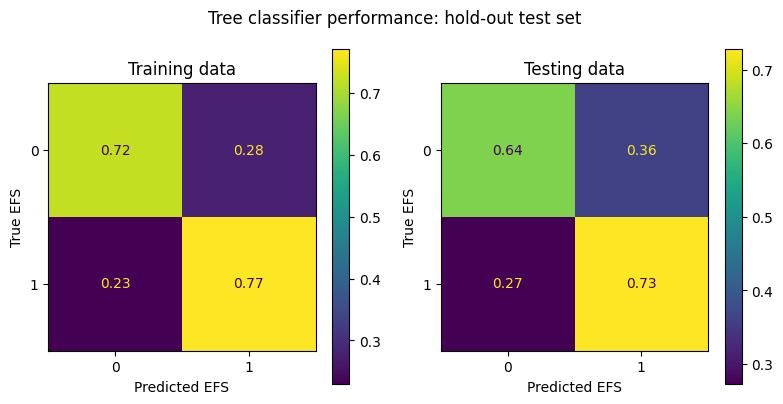

In [11]:
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Tree classifier performance: hold-out test set')

# Make calls with threshold
calls=np.where(training_predictions < 0.5, 0, 1)

cm=confusion_matrix(training_labels_df['efs'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot(ax=axs[0])

axs[0].set_title('Training data')
axs[0].set_xlabel('Predicted EFS')
axs[0].set_ylabel('True EFS')

# Make calls with threshold
calls=np.where(testing_predictions < 0.5, 0, 1)

cm=confusion_matrix(testing_labels_df['efs'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot(ax=axs[1])

axs[1].set_title('Testing data')
axs[1].set_xlabel('Predicted EFS')
axs[1].set_ylabel('True EFS')

fig.tight_layout()
fig.show()

### 4.4. Save learned class features 

In [12]:
# Output file
learned_efs_file=f'{config.PROCESSED_DATA}/02.4-learned_efs.pkl'

learned_efs_feature={
    'Training efs probability': training_predictions,
    'Testing efs probability': testing_predictions,
}

with open(learned_efs_file, 'wb') as output_file:
    pickle.dump(learned_efs_feature, output_file)